<a href="https://colab.research.google.com/github/Hm552/signate-systematic-review-246th/blob/main/keras_%E3%81%AE%E3%82%B3%E3%83%94%E3%83%BC%EF%BC%92.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# データセット保存先ディレクトリ
if 'google.colab' in sys.modules:
    dataset_dir="/content/drive/MyDrive/SRWS"
else:
    dataset_dir="/path/to"

In [ ]:
! pip install --quiet transformers

     |████████████████████████████████| 2.9 MB 5.4 MB/s 
     |████████████████████████████████| 636 kB 73.4 MB/s 
     |████████████████████████████████| 895 kB 71.2 MB/s 
     |████████████████████████████████| 3.3 MB 66.6 MB/s 
     |████████████████████████████████| 52 kB 1.6 MB/s 


In [ ]:
! pip install --quiet tensorflow-addons

     |████████████████████████████████| 1.1 MB 5.2 MB/s 


In [ ]:
import logging
import datetime
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import fbeta_score
from sklearn.utils import class_weight
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from scipy.optimize import minimize, minimize_scalar

from tensorflow.keras import backend as K
import tensorflow as tf
#import tensorflow_addons as tfa

#import transformers
#from transformers import AutoTokenizer, TFAutoModel, TFAutoModelForSequenceClassification

import lightgbm as lgb
from sklearn.svm import SVC

In [ ]:
class Logger:
    """log を残す用のクラス"""
    def __init__(self, path):
        self.general_logger = logging.getLogger(path)
        stream_handler = logging.StreamHandler()
        file_general_handler = logging.FileHandler(os.path.join(path, 'Experiment.log'))
        if len(self.general_logger.handlers) == 0:
            self.general_logger.addHandler(stream_handler)
            self.general_logger.addHandler(file_general_handler)
            self.general_logger.setLevel(logging.INFO)

    def info(self, message):
        # display time
        self.general_logger.info('[{}] - {}'.format(self.now_string(), message))

    @staticmethod
    def now_string():
        return str(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

In [ ]:
import os
INPUT = os.path.join(dataset_dir, "input")
OUTPUT = os.path.join(dataset_dir, "output")
EXP = "211002_1"
OUTPUT_EXP = os.path.join(OUTPUT, EXP)
OUTPUT_EXP_MODEL = os.path.join(OUTPUT_EXP, "model")
OUTPUT_EXP_PREDS = os.path.join(OUTPUT_EXP, "preds")
OUTPUT_EXP_FIG = os.path.join(OUTPUT_EXP, "fig")
SUBMISSION = os.path.join(dataset_dir, "submission")

In [ ]:
warnings.filterwarnings("ignore")  # ignore warnings
logger = Logger(OUTPUT_EXP)  # set logger 

# TPU setting
try:
    TPU = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('Running on TPU ', TPU.cluster_spec().as_dict()['worker'])
except ValueError:
    TPU = None
    print('INFO: Not connected to a TPU runtime')

Running on TPU  ['10.27.242.2:8470']


In [ ]:
def build_auto_model():
    """TFAutoModel"""
    transformer = TFAutoModel.from_pretrained(Config.model)
    input_word_ids = tf.keras.layers.Input(shape=(Config.max_length, ), dtype=tf.int32, name='input_ids')
    attention_mask = tf.keras.layers.Input(shape=(Config.max_length, ), dtype=tf.int32, name='attention_mask')

    x = transformer(input_word_ids, attention_mask=attention_mask)
    #x = x[0][:, 0, :]  # cls

    last_hidden_state = x[0]
    last_hidden_state = tf.keras.layers.Dropout(0.1)(last_hidden_state)
    x_avg = tf.keras.layers.GlobalAveragePooling1D()(last_hidden_state)
    x_max = tf.keras.layers.GlobalMaxPooling1D()(last_hidden_state)
    x = tf.keras.layers.Concatenate()([x_avg, x_max])

    samples = []    
    for n in range(8):
        sample_mask = tf.keras.layers.Dense(64, activation='relu', name = f'dense_{n}')
        sample = tf.keras.layers.Dropout(.5)(x)
        sample = sample_mask(sample)
        sample = tf.keras.layers.Dense(1, activation='sigmoid', name=f'sample_{n}')(sample)
        samples.append(sample)
      
    output = tf.keras.layers.Average(name='output')(samples)

    #output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.models.Model(inputs=[input_word_ids, attention_mask],
                                  outputs=[output])

    optimizer = tfa.optimizers.AdamW(lr=Config.lr, weight_decay=Config.weight_decay)
    model.compile(optimizer = optimizer,
                  loss = [tf.keras.losses.BinaryCrossentropy()],  
                  metrics = ["accuracy"]) 
    return model

In [ ]:
class Config:
    name_v1 = "tf-roberta-base"
    model = "roberta-base"
    max_length = 256
    lr = 0.00002
    weight_decay = 1e-5
    n_fold = 4 
    epochs = 32
    train_batch_size = 64
    steps_per_epochs = 30
    seeds = [2021]
    target_col = "judgement"
    text_col = "text"  # title + abst
    valid_batch_size = 64
    test_batch_size = 64
    class_weight = None
    submit = True
    debug = False

if Config.debug:
    Config.epochs = 1
    Config.n_fold = 2

In [ ]:
def opt_fbeta_threshold(y_true, y_pred):
    """fbeta score計算時のthresholdを最適化"""
    def opt_(x): 
        return -fbeta_score(y_true, y_pred >= x, beta=7)
    result = minimize(opt_, x0=np.array([0.1]), method='Powell')
    best_threshold = result['x'].item()
    return best_threshold


def metrics(y_true, y_pred):
    """fbeta(beta=7)の閾値最適化評価関数"""
    bt = opt_fbeta_threshold(y_true, y_pred)
    print(f"bt:{bt}")
    score = fbeta_score(y_true, y_pred >= bt, beta=7)
    return score


def skf(train, n_splits, random_state):
    """層化KFoldのインデックスのリストを作成"""
    skf = StratifiedKFold(n_splits=n_splits, random_state=random_state, shuffle=True)
    return list(skf.split(train, train[Config.target_col]))


def encode_texts(texts, tokenizer, max_length):
    """text encoding"""
    encoded_dict = tokenizer.batch_encode_plus(
        texts,
        padding = 'max_length',
        truncation = True,
        max_length = max_length,
    )
    return dict(encoded_dict)

def get_dataset(X, y=None, dataset="test"):
    """データをtf.Datasetの形式に変更"""
    if dataset=="train":
        train_dataset = (
            tf.data.Dataset
            .from_tensor_slices((X, y))
            .shuffle(2048)
            .batch(Config.train_batch_size)
            .prefetch(tf.data.experimental.AUTOTUNE)
            )
        if Config.steps_per_epochs is not None:
            train_dataset = train_dataset.repeat()

        return train_dataset

    elif dataset=="valid":
        valid_dataset = (
            tf.data.Dataset
            .from_tensor_slices((X, y))
            .batch(Config.valid_batch_size)
            .prefetch(tf.data.experimental.AUTOTUNE)
        )
        return valid_dataset
    
    elif dataset=="test":
        test_dataset = (
            tf.data.Dataset
            .from_tensor_slices(X)
            .batch(Config.test_batch_size)
            .prefetch(tf.data.experimental.AUTOTUNE)
        )
        return test_dataset


def get_model_and_tokenizer():
    """model&tokenizer を取得 (TPU ok)"""
    if TPU:
        tf.config.experimental_connect_to_cluster(TPU)
        tf.tpu.experimental.initialize_tpu_system(TPU)
        tpu_strategy = tf.distribute.experimental.TPUStrategy(TPU)
        with tpu_strategy.scope():
            model = build_auto_model()
    else:
        model = build_auto_model()

    tokenizer = AutoTokenizer.from_pretrained(Config.model)
    return model, tokenizer


def get_class_weight(target, weight):
    """class weights の作成"""
    if weight == "balanced":
        class_weights = class_weight.compute_class_weight(
            class_weight='balanced',
            classes=np.unique(target),
            y=target)
        class_weights = dict(enumerate(class_weights))
    elif weight is None:
        class_weights = None
    else:
        # ex) weight = {0:0.2, 1:0.98}
        class_weights = weight
    
    return class_weights


def training_v1(train_df, valid_df, model, tokenizer, filepath):
    """training 用の関数"""
    tr_text = encode_texts(texts=train_df[Config.text_col].tolist(), tokenizer=tokenizer, max_length=Config.max_length)
    va_text = encode_texts(texts=valid_df[Config.text_col].tolist(), tokenizer=tokenizer, max_length=Config.max_length)
    tr_dataset = get_dataset(X=tr_text, y=train_df[Config.target_col].values, dataset="train")
    va_dataset = get_dataset(X=va_text, y=valid_df[Config.target_col].values, dataset="valid")

    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath, 
        moniter="val_loss", 
        verbose=1, 
        save_best_only=True, 
        save_weights_only=True,
        mode="min")
    
    model.fit(tr_dataset, 
              epochs=Config.epochs, 
              verbose=1, 
              callbacks=[checkpoint],
              validation_data=va_dataset, 
              steps_per_epoch=Config.steps_per_epochs,
              class_weight=get_class_weight(train_df[Config.target_col], weight=Config.class_weight))


def inference_v1(test_df, model, tokenizer, filepath):
    """推論用の関数"""
    model.load_weights(filepath)
    te_text = encode_texts(texts=test_df[Config.text_col].tolist(), tokenizer=tokenizer, max_length=Config.max_length)
    te_dataset = get_dataset(X=te_text, y=None, dataset="test")
    preds = model.predict(te_dataset)


    return preds.reshape(-1)

'''def greed_encode(data, max_len) :
    input_ids = []
    attention_masks = []
  
    for i in range(len(data.text)):
        
        encoded = tokenizer.encode_plus(data.text[i], add_special_tokens=True, max_length=max_len, pad_to_max_length=True)
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    
    return np.array(input_ids),np.array(attention_masks)'''

def features_from_bertlayer(train_df, test_df, model, tokenizer, filepath, name):
    """推論用の関数"""
    #model.load_weights(filepath)
    cls_layer_model = tf.keras.models.Model(model.input, outputs=model.get_layer(f'dense_1').output)

    tr_text = encode_texts(texts=train_df[Config.text_col].tolist(), tokenizer=tokenizer, max_length=Config.max_length)
    #tr_dataset = get_dataset(X=tr_text, y=train_df[Config.target_col].values, dataset="train")
    te_text = encode_texts(texts=test_df[Config.text_col].tolist(), tokenizer=tokenizer, max_length=Config.max_length)
    #te_dataset = get_dataset(X=te_text, y=None, dataset="test")

    X_train = cls_layer_model.predict([np.array(tr_text['input_ids']), np.array(tr_text['attention_mask'])])
    X_test = cls_layer_model.predict([np.array(te_text['input_ids']), np.array(te_text['attention_mask'])])
    y_train = train_df[Config.target_col].values

    return X_train, X_test, y_train

def lgb_cv(X_train, X_test, y_train, name):
    N_FOLDS = 3
    print(f'LGBM')
    folds = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)
    oof = np.zeros(len(X_train))
    sub = np.zeros(len(X_test))
    params = {'boosting_type': 'dart'}
    for fold_, (train_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
        X_train_cv, y_train_cv = pd.DataFrame(X_train).loc[train_idx], pd.DataFrame(y_train).loc[train_idx]
        X_val, y_val = pd.DataFrame(X_train).loc[val_idx], pd.DataFrame(y_train).loc[val_idx]
        train_data = lgb.Dataset(X_train_cv, label=y_train_cv)
        val_data = lgb.Dataset(X_val, label=y_val)
        watchlist = [train_data, val_data]
        clf = lgb.train(params, train_set = train_data, valid_sets=watchlist)
        oof[val_idx] = clf.predict(X_val)
        sub += clf.predict(X_test)/folds.n_splits
    oof_all_lgb = oof
    sub_all_lgb = sub
    #print(accuracy_score(y_train, np.round(oof).astype(int)),'\n')
    score = metrics(y_train, oof_all_lgb)
    logger.info(f"{name}_lgb >>> val score:{score:.4f}")
    return oof_all_lgb, sub_all_lgb

def svc_cv(X_train, X_test, y_train, name):
    N_FOLDS = 3
    print(f'SVC')
    folds = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)
    oof = np.zeros(len(X_train))
    sub = np.zeros(len(X_test))
    scores = [0 for _ in range(folds.n_splits)]
    for fold_, (train_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
        X_train_cv, y_train_cv = pd.DataFrame(X_train).loc[train_idx], pd.DataFrame(y_train).loc[train_idx]
        X_val, y_val = pd.DataFrame(X_train).loc[val_idx], pd.DataFrame(y_train).loc[val_idx]
        clf = SVC(kernel='rbf', C=1.75, gamma = 0.1, probability = True).fit(X_train_cv, y_train_cv)
        oof[val_idx] = clf.predict_proba(X_val)[:,1]
        sub += clf.predict_proba(X_test)[:,1]/folds.n_splits
    oof_all_svc = oof
    sub_all_svc = sub    
    #print(accuracy_score(y_train, np.round(oof).astype(int)),'\n')
    score = metrics(y_train, oof_all_svc)
    logger.info(f"{name}_svc >>> val score:{score:.4f}")
    return oof_all_svc, sub_all_svc


def train_cv_v1(train, cv, metrics, name, dir):
    """cross validationの実行関数 (train)"""

    oof = np.zeros(len(train))
    for i_fold, (tr_idx, va_idx) in enumerate(cv):
        K.clear_session()
        model, tokenizer = get_model_and_tokenizer()

        tr_df, va_df = train.iloc[tr_idx].reset_index(), train.iloc[va_idx].reset_index()
        filepath = os.path.join(dir, f"{name}_fold{i_fold+1}.h5")

        if not os.path.isfile(filepath):  # 学習済みモデルがあればtrainingしない
            training_v1(tr_df, va_df, model, tokenizer, filepath)
        
        preds = inference_v1(va_df, model, tokenizer, filepath)

        score = metrics(np.array(va_df[Config.target_col]), preds)
        logger.info(f"{name}_fold{i_fold+1} >>> val socre:{score:.4f}")
        oof[va_idx] = preds
    
    score = metrics(np.array(train[Config.target_col]), oof)
    logger.info(f"{name} >>> val score:{score:.4f}")
    return oof
        
def predict_cv_lgb_svc(train, test, name, dir):
    """cross validationの実行関数 (test)"""
    lgb_preds_fold = []
    svc_preds_fold = []
    lgb_oof_fold = []
    svc_oof_fold = []
    for i_fold in range(Config.n_fold):
        model, tokenizer = get_model_and_tokenizer()
        filepath = os.path.join(dir, f"{name}_fold{i_fold+1}.h5")
        # grab last layer and use LGBM and SVC
        X_train, X_test, y_train = features_from_bertlayer(train, test, model, tokenizer, filepath, name)
        lgb_oof, lgb_preds = lgb_cv(X_train, X_test, y_train, name)
        svc_oof, svc_preds = svc_cv(X_train, X_test, y_train, name)

        lgb_preds_fold.append(lgb_preds)
        svc_preds_fold.append(svc_preds)
        lgb_oof_fold.append(lgb_oof)
        svc_oof_fold.append(svc_oof)

        logger.info(f"{name}_fold{i_fold+1} inference")
    
    lgb_pred = np.mean(lgb_preds_fold, axis=0)
    svc_pred = np.mean(svc_preds_fold, axis=0)
    lgb_oof_ = np.mean(lgb_oof_fold, axis=0)
    svc_oof_ = np.mean(svc_oof_fold, axis=0)
    return lgb_pred, svc_pred, lgb_oof_, svc_oof_

def predict_cv_v1(train, test, name, dir):
    """cross validationの実行関数 (test)"""
    preds_fold = []
    for i_fold in range(Config.n_fold):
        model, tokenizer = get_model_and_tokenizer()
        filepath = os.path.join(dir, f"{name}_fold{i_fold+1}.h5")
        preds = inference_v1(test, model, tokenizer, filepath)
        preds_fold.append(preds)

        logger.info(f"{name}_fold{i_fold+1} inference")
    
    pred = np.mean(preds_fold, axis=0)
    return pred

def visualize_confusion_matrix(
        y_true,
        pred_label,
        height=.6,
        labels=None):
    """混合行列をプロット 
    (https://www.guruguru.science/competitions/11/discussions/2fb11851-67d0-4e96-a4b1-5629b944f363/)"""
    
    conf = confusion_matrix(y_true=y_true,
                            y_pred=pred_label,
                            normalize='true')

    n_labels = len(conf)
    size = n_labels * height
    fig, ax = plt.subplots(figsize=(size * 4, size * 3))
    sns.heatmap(conf, cmap='Blues', ax=ax, annot=True, fmt='.2f')
    ax.set_ylabel('Label')
    ax.set_xlabel('Predict')

    if labels is not None:
        ax.set_yticklabels(labels)
        ax.set_xticklabels(labels)
        ax.tick_params('y', labelrotation=0)
        ax.tick_params('x', labelrotation=90)

    plt.show()
    return fig

In [ ]:
def main():
    # load data
    train = pd.read_csv(os.path.join(INPUT, "train.csv"))
    test = pd.read_csv(os.path.join(INPUT, "test.csv"))

    if Config.debug:
        train = train.sample(1000, random_state=Config.seeds[0]).reset_index(drop=True)
        test = test.sample(1000, random_state=Config.seeds[0]).reset_index(drop=True)

    # preprocess
    train["text"] = train["title"] + " " + train["abstract"].fillna("")
    test["text"] = test["title"] + " " + test["abstract"].fillna("")

    # training
    oof_df = pd.DataFrame()
    for seed in Config.seeds:
        name = f"{Config.name_v1}-{seed}"
        oof = train_cv_v1(train, 
                        cv=skf(train, n_splits=Config.n_fold, random_state=seed),
                        metrics=metrics, 
                        name=name, 
                        dir=OUTPUT_EXP_MODEL)
        oof_df[name] = oof
    oof_df.to_csv(os.path.join(OUTPUT_EXP_PREDS, "tf_oof.csv"), index=False)  # oof 予測値(prob)を保存

    #oof_df = pd.read_csv(os.path.join(OUTPUT_EXP_PREDS, "tf_oof.csv"))  # oof 予測値(prob)を保存

    # inference
    preds_df = pd.DataFrame()
    for seed in Config.seeds:
        name = f"{Config.name_v1}-{seed}"
        pred = predict_cv_v1(train, test, name, dir=OUTPUT_EXP_MODEL)
        preds_df[name] = pred
    
    preds_df.to_csv(os.path.join(OUTPUT_EXP_PREDS, "tf_preds.csv"), index=False)  # test予測値(prob)を保存
    #preds_df = pd.read_csv(os.path.join(OUTPUT_EXP_PREDS, "tf_oof.csv"))  # oof 予測値(prob)を保存
    
    # inference
    for seed in Config.seeds:
        name = f"{Config.name_v1}-{seed}"
        lgb_pred, svc_pred, lgb_oof_, svc_oof_ = predict_cv_lgb_svc(train, test, name, dir=OUTPUT_EXP_MODEL)
        preds_df[name + "_lgb"] = lgb_pred
        preds_df[name + "_svc"] = svc_pred
        oof_df[name + "_lgb"] = lgb_oof_
        oof_df[name + "_svc"] = svc_oof_
    
    oof_df.to_csv(os.path.join(OUTPUT_EXP_PREDS, "oof.csv"), index=False)  # oof 予測値(prob)
    preds_df.to_csv(os.path.join(OUTPUT_EXP_PREDS, "preds.csv"), index=False)  # test予測値(prob)を保存

    y_true = train[Config.target_col]
    y_pred = oof_df.mean(axis=1)

    best_threshold = opt_fbeta_threshold(y_true.values, y_pred.values)
    oof_score = fbeta_score(y_true, y_pred >= best_threshold, beta=7)
    comments = f"score:{oof_score:.4f}/threshold:{best_threshold}"  # 最終的なスコアと閾値 (スペースがあるとsubmit時のコメントエラーが出る)
    logger.info(comments)

    fig = visualize_confusion_matrix(y_true, y_pred>=best_threshold)  # 混合行列を表示&save
    fig.savefig(os.path.join(OUTPUT_EXP_FIG, "cm.png"), dpi=300)

    # submit
    if Config.submit:
        sub_df = pd.read_csv(os.path.join(INPUT, "sample_submit.csv"), header=None)
        sub_df.columns = ["id", "judgement"]

        preds = preds_df.mean(axis=1)
        sub_df["judgement"] = (preds.values >= best_threshold) * 1
        
        filepath = os.path.join(SUBMISSION, f"{EXP}.csv")
        sub_df.to_csv(filepath, index=False, header=False)
        
        # signate api を使ってsubmit
        #! signate submit --competition-id=471 $filepath --note $comments

In [ ]:
if __name__ == "__main__":
    main()

INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.96.177.82:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.96.177.82:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


KeyboardInterrupt: ignored

In [ ]:
train = pd.read_csv(os.path.join(INPUT, "train.csv"))
#train = train.sample(1000, random_state=Config.seeds[0]).reset_index(drop=True)
oof_df = pd.read_csv(os.path.join(OUTPUT_EXP_PREDS, "oof.csv"))

sum = pd.concat([train, oof_df], axis = 1)
sum.head()

,id,title,abstract,judgement,tf-roberta-base-2021,tf-roberta-base-2021_lgb,tf-roberta-base-2021_svc
0,0,One-year age changes in MRI brain volumes in o...,Longitudinal studies indicate that declines in...,0,0.000279,0.004342,0.022103
1,1,Supportive CSF biomarker evidence to enhance t...,The present study was undertaken to validate t...,0,0.086450,0.026965,0.029923
2,2,Occurrence of basal ganglia germ cell tumors w...,Objective: To report a case series in which ba...,0,0.000483,0.012799,0.027146
3,3,New developments in diagnosis and therapy of C...,The etiology and pathogenesis of idiopathic ch...,0,0.091356,0.008482,0.026805
4,4,Prolonged shedding of SARS-CoV-2 in an elderly...,NaN,0,0.000567,0.015342,0.019317


In [ ]:
sum['ensemble'] = oof_df.mean(axis = 1)

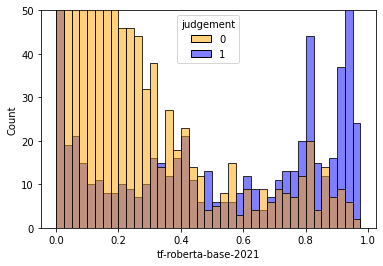

In [ ]:
import seaborn as sns
sns.histplot(x="tf-roberta-base-2021", binwidth=0.025, data=sum, hue="judgement", palette={0:"Orange", 1:"Blue"}, alpha = 0.5)
plt.ylim(0,50)
plt.show()

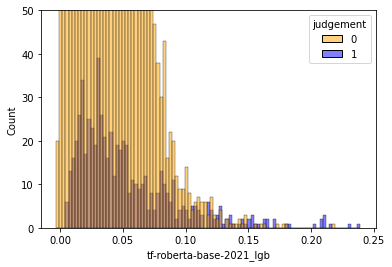

In [ ]:
sns.histplot(x="tf-roberta-base-2021_lgb", binwidth=0.0025, data=sum, hue="judgement", palette={0:"Orange", 1:"Blue"}, alpha = 0.5)
plt.ylim(0,50)
plt.show()

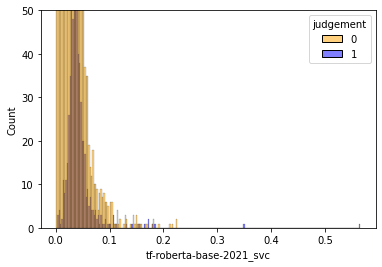

In [ ]:
sns.histplot(x="tf-roberta-base-2021_svc", binwidth=0.0025, data=sum, hue="judgement", palette={0:"Orange", 1:"Blue"}, alpha = 0.5)
plt.ylim(0,50)
plt.show()

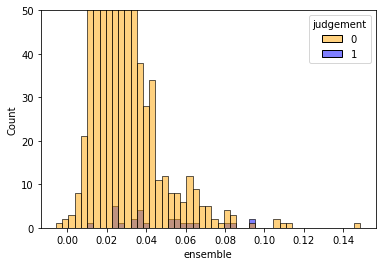

In [ ]:
sns.histplot(x="ensemble", data=sum, hue="judgement", palette={0:"Orange", 1:"Blue"}, alpha = 0.5)
plt.ylim(0,50)
plt.show()

In [ ]:
preds_df = pd.read_csv(os.path.join(OUTPUT_EXP_PREDS, "preds.csv"))
preds_df.head()

,tf-roberta-base-2021,tf-roberta-base-2021_lgb,tf-roberta-base-2021_svc
0,0.000360,0.017087,0.018506
1,0.002691,0.013523,0.008553
2,0.000728,0.008139,0.030508
3,0.000846,0.019630,0.025787
4,0.000475,0.017953,0.025542


In [ ]:
preds_df.corr()

,tf-roberta-base-2021,tf-roberta-base-2021_lgb,tf-roberta-base-2021_svc
tf-roberta-base-2021,1.000000,0.428993,0.332520
tf-roberta-base-2021_lgb,0.428993,1.000000,0.518834
tf-roberta-base-2021_svc,0.332520,0.518834,1.000000


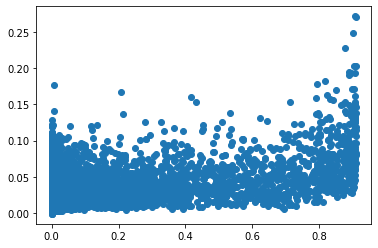

In [ ]:
plt.scatter(preds_df.iloc[:,0], preds_df.iloc[:,1])
plt.show()

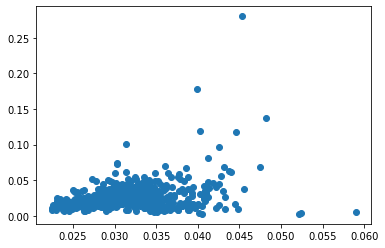

In [ ]:
plt.scatter(preds_df.iloc[:,0], preds_df.iloc[:,2])
plt.show()

In [ ]:
"name" + "_svc"

'namesvc'

In [ ]:
def get_split(text):
  l_total = []
  l_parcial = []
  if len(text.split())//128 >0:
    n = len(text.split())//128
  else: 
    n = 1
  for w in range(n):
    if w == 0:
      l_parcial = text.split()[:128]
      l_total.append(" ".join(l_parcial))
    else:
      l_parcial = text.split()[w*100:w*100 + 128]
      l_total.append(" ".join(l_parcial))
  return l_total

In [ ]:
train = pd.read_csv(os.path.join(INPUT, "train.csv"))
test = pd.read_csv(os.path.join(INPUT, "test.csv"))

train = train.sample(1000, random_state=Config.seeds[0]).reset_index(drop=True)
test = test.sample(1000, random_state=Config.seeds[0]).reset_index(drop=True)

# preprocess
train["abstract"] = train["abstract"].fillna("").apply(get_split)
train_l = []
label_l = []
for idx,row in train.iterrows():
  for l in row['abstract']:
    train_l.append(row['title'] + " " + l)
    label_l.append(row['judgement'])
train = pd.DataFrame({'text':train_l, 'judgement':label_l})

test["abstract"] = test["abstract"].fillna("").apply(get_split)
test_l = []
test_l_idx = []
for idx,row in test.iterrows():
  for l in row['abstract']:
    test_l.append(row['title'] + " " + l)
    test_l_idx.append(idx)
    
test = pd.DataFrame({'text':test_l, 'id':test_l_idx})

In [ ]:
test.head()

,text,id
0,Volume reduction in cerebral blood flow in pat...,0
1,Potential roles of social distancing in mitiga...,1
2,Contrast-Enhanced Ultrasound in Patients With ...,2
3,TAVR procedures with self-expandable valves ca...,3
4,TAVR procedures with self-expandable valves ca...,3


In [ ]:
train.head(100)

,text,judgement
0,Mutations in the colony stimulating factor 1 r...,0
1,A case series and literature review of multipl...,0
2,COVID-19 associated central nervous system vas...,0
3,Antiretrovirals and risk of COVID-19 diagnosis...,0
4,Chronic hypoxia in the human neuroblastoma SH-...,0
...,...,...
95,Modeling Alzheimer's disease and other proteop...,0
96,Gout management and outcomes during the COVID-...,0
97,Gout management and outcomes during the COVID-...,0
98,Statistical image analysis of cerebral blood f...,0


In [ ]:
train.iloc[98]['text']

'Statistical image analysis of cerebral blood flow in vascular dementia with small-vessel disease. Small-vessel disease with dementia which is the most frequent type of vascular dementia (VaD) often shows a cerebral blood flow (CBF) distribution with no obvious focal abnormalities and is therefore difficult to evaluate objectively. In this study we combined CBF SPECT with 3-dimensional fractal analysis (3D-FA) to quantitatively assess the heterogeneity of CBF distribution and with 3-dimensional stereotactic surface projections (3D-SSP) to evaluate the distribution of CBF. We then evaluated the clinical validity of these techniques for the imaging diagnosis of VaD. METHODS: The subjects consisted of 17 patients who were diagnosed as having VaD due to small-vessel disease (VaD group) on the basis of a full clinical examination including history neuropsychologic tests neurologic examination and neuroimaging methods and 20 healthy volunteers (control group). CBF SPECT was performed'

In [ ]:
train.iloc[99]['text']

'Statistical image analysis of cerebral blood flow in vascular dementia with small-vessel disease. group) on the basis of a full clinical examination including history neuropsychologic tests neurologic examination and neuroimaging methods and 20 healthy volunteers (control group). CBF SPECT was performed with (99m)Tc-hexamethylpropyleneamine oxime and the reconstructed images were subjected to image processing by 3D-FA and 3D-SSP. Based on the results the fractal dimension (FD) was compared between the VaD and control groups and the distribution pattern of CBF was examined in the VaD group. RESULTS: The mean FD values in the VaD group and the control group were 1.093 +/- 0.153 and 0.853 +/- 0.062 (mean +/- SD) respectively. The mean FD value in the VaD group was significantly higher than that in the control group (P < 0.0001). 3D-SSP analysis in the VaD group showed that there were 2'

In [ ]:
train.shape[0]

1286

In [ ]:
a = [1,2,3]
b = [4,5,6]
pd.DataFrame([a, b])

,0,1,2
0,1,2,3
1,4,5,6


In [ ]:
def main():
    # load data
    train = pd.read_csv(os.path.join(INPUT, "train.csv"))
    test = pd.read_csv(os.path.join(INPUT, "test.csv"))

    if Config.debug:
        train = train.sample(1000, random_state=Config.seeds[0]).reset_index(drop=True)
        test = test.sample(1000, random_state=Config.seeds[0]).reset_index(drop=True)

    train_full = train[~train['abstract'].isnull()]
    test_full = test[~test['abstract'].isnull()]
    test_title = test[test['abstract'].isnull()]

    EXP = "210913_1/fullmodel"
    OUTPUT_EXP = os.path.join(OUTPUT, EXP)
    OUTPUT_EXP_MODEL = os.path.join(OUTPUT_EXP, "model")
    OUTPUT_EXP_PREDS = os.path.join(OUTPUT_EXP, "preds")
    OUTPUT_EXP_FIG = os.path.join(OUTPUT_EXP, "fig")

   # preprocess
    train_full["text"] = train_full["title"] + " " + train_full["abstract"]
    test_full["text"] = test_full["title"] + " " + test_full["abstract"]

    # training
    oof_df = pd.DataFrame()
    for seed in Config.seeds:
        name = f"{Config.name_v1}-{seed}"
        oof = train_cv_v1(train_full, 
                        cv=skf(train_full, n_splits=Config.n_fold, random_state=seed),
                        metrics=metrics, 
                        name=name, 
                        dir=OUTPUT_EXP_MODEL)
        oof_df[name] = oof

    oof_df.to_csv(os.path.join(OUTPUT_EXP_PREDS, "oof.csv"), index=False)  # oof 予測値(prob)を保存

    y_true = train_full[Config.target_col]
    y_pred = oof_df.mean(axis=1)

    best_threshold = opt_fbeta_threshold(y_true.values, y_pred.values)
    oof_score = fbeta_score(y_true, y_pred >= best_threshold, beta=7)
    comments = f"score:{oof_score:.4f}/threshold:{best_threshold}"  # 最終的なスコアと閾値 (スペースがあるとsubmit時のコメントエラーが出る)
    logger.info(comments)

    fig = visualize_confusion_matrix(y_true, y_pred>=best_threshold)  # 混合行列を表示&save
    fig.savefig(os.path.join(OUTPUT_EXP_FIG, "cm.png"), dpi=300)

    # inference
    preds_df_full = pd.DataFrame()
    preds_df_full['id'] = test_full['id'].values
    for seed in Config.seeds:
        name = f"{Config.name_v1}-{seed}"
        preds = predict_cv_v1(test_full, name, dir=OUTPUT_EXP_MODEL)
        judgement = (preds >= best_threshold) * 1
        preds_df_full['preds'] = preds
        preds_df_full['judgement'] = judgement

        preds_df_full.to_csv(os.path.join(OUTPUT_EXP_PREDS, "preds.csv"), index=False)  # test予測値(prob)を保存
    
    EXP = "210913_1/titlemodel"
    OUTPUT_EXP = os.path.join(OUTPUT, EXP)
    OUTPUT_EXP_MODEL = os.path.join(OUTPUT_EXP, "model")
    OUTPUT_EXP_PREDS = os.path.join(OUTPUT_EXP, "preds")
    OUTPUT_EXP_FIG = os.path.join(OUTPUT_EXP, "fig")

    Config.max_length = 64

    # preprocess
    train_full["text"] = train_full["title"]
    test_title["text"] = test_title["title"]

    # training
    oof_df = pd.DataFrame()
    for seed in Config.seeds:
        name = f"{Config.name_v1}-{seed}"
        oof = train_cv_v1(train_full, 
                        cv=skf(train_full, n_splits=Config.n_fold, random_state=seed),
                        metrics=metrics, 
                        name=name, 
                        dir=OUTPUT_EXP_MODEL)
        oof_df[name] = oof

    oof_df.to_csv(os.path.join(OUTPUT_EXP_PREDS, "oof.csv"), index=False)  # oof 予測値(prob)を保存

    y_true = train_full[Config.target_col]
    y_pred = oof_df.mean(axis=1)

    best_threshold = opt_fbeta_threshold(y_true.values, y_pred.values)
    oof_score = fbeta_score(y_true, y_pred >= best_threshold, beta=7)
    comments = f"score:{oof_score:.4f}/threshold:{best_threshold}"  # 最終的なスコアと閾値 (スペースがあるとsubmit時のコメントエラーが出る)
    logger.info(comments)

    fig = visualize_confusion_matrix(y_true, y_pred>=best_threshold)  # 混合行列を表示&save
    fig.savefig(os.path.join(OUTPUT_EXP_FIG, "cm.png"), dpi=300)

    # inference
    preds_df_title = pd.DataFrame()
    preds_df_title['id'] = test_title['id'].values
    for seed in Config.seeds:
        name = f"{Config.name_v1}-{seed}"
        preds = predict_cv_v1(test_title, name, dir=OUTPUT_EXP_MODEL)
        judgement = (preds >= best_threshold) * 1
        preds_df_title['preds'] = preds
        preds_df_title['judgement'] = judgement

        preds_df_title.to_csv(os.path.join(OUTPUT_EXP_PREDS, "preds.csv"), index=False)  # test予測値(prob)を保存

    # submit
    if Config.submit:
        sub_df = pd.read_csv(os.path.join(INPUT, "sample_submit.csv"), header=None)
        sub_df.columns = ["id", "judgement"]
        preds_df_full = preds_df_full[['id', 'judgement']]
        preds_df_title = preds_df_title[['id', 'judgement']]
        sub_df = pd.merge(sub_df, preds_df_full, how = 'left', on = 'id')
        sub_df = pd.merge(sub_df, preds_df_title, how = 'left', on = 'id')
        sub_df = sub_df.set_index('id', drop = True)
        sub_df['judgement'] = sub_df.fillna(0).sum(axis = 1)

        #preds = preds_df.mean(axis=1)
        #sub_df["judgement"] = (preds.values >= best_threshold) * 1
        sub_df = sub_df['judgement'].reset_index()
        filepath = os.path.join(SUBMISSION, f"{EXP}.csv")
        sub_df.to_csv(filepath, index=False, header=False)

In [ ]:
EXP = "210913_1/fullmodel"
OUTPUT_EXP = os.path.join(OUTPUT, EXP)
OUTPUT_EXP_PREDS = os.path.join(OUTPUT_EXP, "preds")

oof_df = pd.read_csv(os.path.join(OUTPUT_EXP_PREDS, "oof.csv"))  # oof 予測値(prob)を保存

In [ ]:
oof_df.head()

,tf-roberta-base-2021
0,0.000277
1,0.002845
2,0.000207
3,0.008549
4,0.000666


In [ ]:
train = pd.read_csv(os.path.join(INPUT, "train.csv"))
train_full = train[~train['abstract'].isnull()]

oof_df.columns = ['preds']
oof_df['true'] = train_full['judgement'].values
oof_df.head()

,preds,true
0,0.000277,0
1,0.002845,0
2,0.000207,0
3,0.008549,0
4,0.000666,0


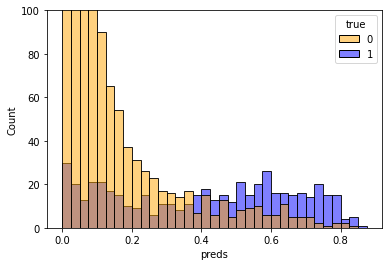

In [ ]:
import seaborn as sns
sns.histplot(x="preds", data=oof_df, hue="true", binwidth=0.025, palette={0:"Orange", 1:"Blue"}, alpha = 0.5)
plt.ylim(0,100)
plt.show()

In [ ]:
EXP = "210913_1/titlemodel"
OUTPUT_EXP = os.path.join(OUTPUT, EXP)
OUTPUT_EXP_PREDS = os.path.join(OUTPUT_EXP, "preds")

oof_df = pd.read_csv(os.path.join(OUTPUT_EXP_PREDS, "oof.csv"))  # oof 予測値(prob)を保存
oof_df.columns = ['preds']
train_full = train[~train['abstract'].isnull()]
oof_df['true'] = train_full['judgement'].values
oof_df.head()

,preds,true
0,0.000322,0
1,0.021497,0
2,0.000256,0
3,0.020559,0
4,0.001713,0


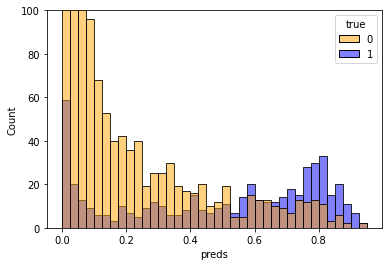

In [ ]:
import seaborn as sns
sns.histplot(x="preds", data=oof_df, hue="true", binwidth=0.025, palette={0:"Orange", 1:"Blue"}, alpha = 0.5)
plt.ylim(0,100)
plt.show()

In [ ]:

preds = predict_cv_v1(test, name, dir=OUTPUT_EXP_MODEL)

INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.58.92.154:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.58.92.154:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 128) dtype=int32>]


[2021-09-11 15:39:16] - tf-roberta-base-2021_fold1 inference
INFO:/content/drive/MyDrive/SRWS/output/210911_1:[2021-09-11 15:39:16] - tf-roberta-base-2021_fold1 inference


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.58.92.154:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.58.92.154:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 128) dtype=int32>]


[2021-09-11 15:41:04] - tf-roberta-base-2021_fold2 inference
INFO:/content/drive/MyDrive/SRWS/output/210911_1:[2021-09-11 15:41:04] - tf-roberta-base-2021_fold2 inference


In [ ]:
print(preds)

[0.02965796 0.0318905  0.03118706 ... 0.05664915 0.02666865 0.03002353]


In [ ]:
len(preds)

1259

In [ ]:
test.shape[0]

1259

In [ ]:
preds_df=pd.DataFrame()
preds_ = pd.Series(preds, index = test['id'])
preds_ = preds_.groupby('id').mean()
preds_df[name] = preds_.values

In [ ]:
print(preds_.values)

[0.02965796 0.0318905  0.03118706 0.03904574 0.03616802 0.02990989
 0.02892029 0.030166   0.02966553 0.0236733  0.0328501  0.02799098
 0.04994561 0.02516021 0.0311148  0.0319514  0.03118195 0.05238925
 0.0309484  0.02654967 0.03328596 0.03155206 0.03177002 0.0356877
 0.02869388 0.03246411 0.03359237 0.03399441 0.02897735 0.03073488
 0.03352317 0.03292879 0.03014627 0.04898536 0.02573529 0.03086278
 0.03662838 0.05103783 0.03344778 0.03236644 0.05649556 0.03142247
 0.0324713  0.03028677 0.05273116 0.03215093 0.02667601 0.03114451
 0.05446915 0.03058939 0.03247914 0.03290966 0.03392817 0.03076363
 0.0314103  0.03271852 0.02886222 0.03660081 0.03070047 0.02927957
 0.02827559 0.03652841 0.0278084  0.05786638 0.03539581 0.03398337
 0.02505381 0.03212968 0.02935697 0.03247287 0.03105465 0.03101388
 0.05829953 0.03345947 0.0295607  0.02991053 0.02841775 0.03308466
 0.03050378 0.03279208 0.02862088 0.03374735 0.0341948  0.03248279
 0.02781427 0.03402539 0.02458905 0.03114174 0.02338572 0.02665

In [ ]:
preds_df

,tf-roberta-base-2021
0,0.029658
1,0.031890
2,0.031187
3,0.039046
4,0.036168
...,...
995,0.033526
996,0.050144
997,0.056649
998,0.026669


INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.102.27.98:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.102.27.98:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/657M [00:00<?, ?B/s]

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int32>]


[2021-09-15 12:53:52] - tf-roberta-base-2021_fold1 >>> val socre:0.9455
INFO:/content/drive/MyDrive/SRWS/output/210913_1:[2021-09-15 12:53:52] - tf-roberta-base-2021_fold1 >>> val socre:0.9455


bt:0.02452911192585634
INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.102.27.98:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.102.27.98:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int32>]


[2021-09-15 12:55:56] - tf-roberta-base-2021_fold2 >>> val socre:0.9108
INFO:/content/drive/MyDrive/SRWS/output/210913_1:[2021-09-15 12:55:56] - tf-roberta-base-2021_fold2 >>> val socre:0.9108


bt:0.02235559357082307
INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.102.27.98:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.102.27.98:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int32>]


[2021-09-15 12:57:56] - tf-roberta-base-2021_fold3 >>> val socre:0.8957
INFO:/content/drive/MyDrive/SRWS/output/210913_1:[2021-09-15 12:57:56] - tf-roberta-base-2021_fold3 >>> val socre:0.8957


bt:0.01482106391804089
INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.102.27.98:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.102.27.98:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int32>]


[2021-09-15 13:00:04] - tf-roberta-base-2021_fold4 >>> val socre:0.7966
INFO:/content/drive/MyDrive/SRWS/output/210913_1:[2021-09-15 13:00:04] - tf-roberta-base-2021_fold4 >>> val socre:0.7966


bt:0.10000000001787654
INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.102.27.98:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.102.27.98:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int32>]


[2021-09-15 13:02:10] - tf-roberta-base-2021_fold5 >>> val socre:0.8974
INFO:/content/drive/MyDrive/SRWS/output/210913_1:[2021-09-15 13:02:10] - tf-roberta-base-2021_fold5 >>> val socre:0.8974


bt:0.030827936167374184


[2021-09-15 13:02:11] - tf-roberta-base-2021 >>> val score:0.9013
INFO:/content/drive/MyDrive/SRWS/output/210913_1:[2021-09-15 13:02:11] - tf-roberta-base-2021 >>> val score:0.9013


bt:0.02238218562582136


[2021-09-15 13:02:12] - score:0.9013/threshold:0.02238218562582136
INFO:/content/drive/MyDrive/SRWS/output/210913_1:[2021-09-15 13:02:12] - score:0.9013/threshold:0.02238218562582136


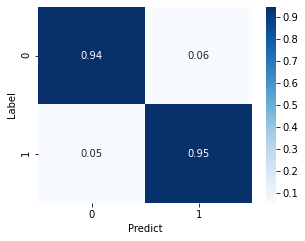

INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.102.27.98:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.102.27.98:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int32>]


[2021-09-15 13:06:37] - tf-roberta-base-2021_fold1 inference
INFO:/content/drive/MyDrive/SRWS/output/210913_1:[2021-09-15 13:06:37] - tf-roberta-base-2021_fold1 inference


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.102.27.98:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.102.27.98:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int32>]


[2021-09-15 13:11:24] - tf-roberta-base-2021_fold2 inference
INFO:/content/drive/MyDrive/SRWS/output/210913_1:[2021-09-15 13:11:24] - tf-roberta-base-2021_fold2 inference


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.102.27.98:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.102.27.98:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int32>]


[2021-09-15 13:15:51] - tf-roberta-base-2021_fold3 inference
INFO:/content/drive/MyDrive/SRWS/output/210913_1:[2021-09-15 13:15:51] - tf-roberta-base-2021_fold3 inference


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.102.27.98:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.102.27.98:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int32>]


[2021-09-15 13:20:34] - tf-roberta-base-2021_fold4 inference
INFO:/content/drive/MyDrive/SRWS/output/210913_1:[2021-09-15 13:20:34] - tf-roberta-base-2021_fold4 inference


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.102.27.98:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.102.27.98:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int32>]


[2021-09-15 13:25:20] - tf-roberta-base-2021_fold5 inference
INFO:/content/drive/MyDrive/SRWS/output/210913_1:[2021-09-15 13:25:20] - tf-roberta-base-2021_fold5 inference


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.102.27.98:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.102.27.98:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/32


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'IteratorGetNext:0' shape=(None, 64) dtype=int32>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 64) dtype=int32>, <tf.Tensor 'IteratorGetNext:2' shape=(None,) dtype=int64>]


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'IteratorGetNext:0' shape=(None, 64) dtype=int32>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 64) dtype=int32>, <tf.Tensor 'IteratorGetNext:2' shape=(None,) dtype=int64>]


30/30 [==============================] - ETA: 0s - loss: 0.2314 - accuracy: 0.8891

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 64) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 64) dtype=int32>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None,) dtype=int64>]


30/30 [==============================] - 114s 695ms/step - loss: 0.2314 - accuracy: 0.8891 - val_loss: 0.1029 - val_accuracy: 0.9776

Epoch 00001: val_loss improved from inf to 0.10294, saving model to /content/drive/MyDrive/SRWS/output/210913_1/titlemodel/model/tf-roberta-base-2021_fold1.h5
Epoch 2/32
30/30 [==============================] - 5s 160ms/step - loss: 0.1058 - accuracy: 0.9771 - val_loss: 0.0896 - val_accuracy: 0.9776

Epoch 00002: val_loss improved from 0.10294 to 0.08956, saving model to /content/drive/MyDrive/SRWS/output/210913_1/titlemodel/model/tf-roberta-base-2021_fold1.h5
Epoch 3/32
30/30 [==============================] - 5s 162ms/step - loss: 0.0958 - accuracy: 0.9745 - val_loss: 0.0801 - val_accuracy: 0.9782

Epoch 00003: val_loss improved from 0.08956 to 0.08014, saving model to /content/drive/MyDrive/SRWS/output/210913_1/titlemodel/model/tf-roberta-base-2021_fold1.h5
Epoch 4/32
30/30 [==============================] - 5s 160ms/step - loss: 0.0747 - accuracy: 0.

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 64) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 64) dtype=int32>]


[2021-09-15 13:33:42] - tf-roberta-base-2021_fold1 >>> val socre:0.7965
INFO:/content/drive/MyDrive/SRWS/output/210913_1:[2021-09-15 13:33:42] - tf-roberta-base-2021_fold1 >>> val socre:0.7965


bt:0.10180068719185759
INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.102.27.98:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.102.27.98:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/32


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'IteratorGetNext:0' shape=(None, 64) dtype=int32>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 64) dtype=int32>, <tf.Tensor 'IteratorGetNext:2' shape=(None,) dtype=int64>]


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'IteratorGetNext:0' shape=(None, 64) dtype=int32>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 64) dtype=int32>, <tf.Tensor 'IteratorGetNext:2' shape=(None,) dtype=int64>]


30/30 [==============================] - ETA: 0s - loss: 0.1675 - accuracy: 0.9745

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 64) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 64) dtype=int32>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None,) dtype=int64>]


30/30 [==============================] - 117s 688ms/step - loss: 0.1675 - accuracy: 0.9745 - val_loss: 0.1045 - val_accuracy: 0.9776

Epoch 00001: val_loss improved from inf to 0.10448, saving model to /content/drive/MyDrive/SRWS/output/210913_1/titlemodel/model/tf-roberta-base-2021_fold2.h5
Epoch 2/32
30/30 [==============================] - 5s 161ms/step - loss: 0.1090 - accuracy: 0.9776 - val_loss: 0.0954 - val_accuracy: 0.9776

Epoch 00002: val_loss improved from 0.10448 to 0.09537, saving model to /content/drive/MyDrive/SRWS/output/210913_1/titlemodel/model/tf-roberta-base-2021_fold2.h5
Epoch 3/32
30/30 [==============================] - 5s 162ms/step - loss: 0.1030 - accuracy: 0.9750 - val_loss: 0.0854 - val_accuracy: 0.9776

Epoch 00003: val_loss improved from 0.09537 to 0.08540, saving model to /content/drive/MyDrive/SRWS/output/210913_1/titlemodel/model/tf-roberta-base-2021_fold2.h5
Epoch 4/32
30/30 [==============================] - 5s 162ms/step - loss: 0.0940 - accuracy: 0.

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 64) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 64) dtype=int32>]


[2021-09-15 13:42:18] - tf-roberta-base-2021_fold2 >>> val socre:0.8640
INFO:/content/drive/MyDrive/SRWS/output/210913_1:[2021-09-15 13:42:18] - tf-roberta-base-2021_fold2 >>> val socre:0.8640


bt:0.0033457885958052412
INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.102.27.98:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.102.27.98:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/32


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'IteratorGetNext:0' shape=(None, 64) dtype=int32>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 64) dtype=int32>, <tf.Tensor 'IteratorGetNext:2' shape=(None,) dtype=int64>]


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'IteratorGetNext:0' shape=(None, 64) dtype=int32>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 64) dtype=int32>, <tf.Tensor 'IteratorGetNext:2' shape=(None,) dtype=int64>]


30/30 [==============================] - ETA: 0s - loss: 0.1468 - accuracy: 0.9818

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 64) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 64) dtype=int32>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None,) dtype=int64>]


30/30 [==============================] - 117s 684ms/step - loss: 0.1468 - accuracy: 0.9818 - val_loss: 0.1113 - val_accuracy: 0.9776

Epoch 00001: val_loss improved from inf to 0.11133, saving model to /content/drive/MyDrive/SRWS/output/210913_1/titlemodel/model/tf-roberta-base-2021_fold3.h5
Epoch 2/32
30/30 [==============================] - 5s 163ms/step - loss: 0.1120 - accuracy: 0.9776 - val_loss: 0.0930 - val_accuracy: 0.9776

Epoch 00002: val_loss improved from 0.11133 to 0.09304, saving model to /content/drive/MyDrive/SRWS/output/210913_1/titlemodel/model/tf-roberta-base-2021_fold3.h5
Epoch 3/32
30/30 [==============================] - 5s 165ms/step - loss: 0.1080 - accuracy: 0.9755 - val_loss: 0.0812 - val_accuracy: 0.9776

Epoch 00003: val_loss improved from 0.09304 to 0.08119, saving model to /content/drive/MyDrive/SRWS/output/210913_1/titlemodel/model/tf-roberta-base-2021_fold3.h5
Epoch 4/32
30/30 [==============================] - 5s 164ms/step - loss: 0.0788 - accuracy: 0.

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 64) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 64) dtype=int32>]


[2021-09-15 13:50:53] - tf-roberta-base-2021_fold3 >>> val socre:0.8737
INFO:/content/drive/MyDrive/SRWS/output/210913_1:[2021-09-15 13:50:53] - tf-roberta-base-2021_fold3 >>> val socre:0.8737


bt:0.004088891956010202
INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.102.27.98:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.102.27.98:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/32


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'IteratorGetNext:0' shape=(None, 64) dtype=int32>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 64) dtype=int32>, <tf.Tensor 'IteratorGetNext:2' shape=(None,) dtype=int64>]


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'IteratorGetNext:0' shape=(None, 64) dtype=int32>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 64) dtype=int32>, <tf.Tensor 'IteratorGetNext:2' shape=(None,) dtype=int64>]


30/30 [==============================] - ETA: 0s - loss: 0.1704 - accuracy: 0.9729

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 64) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 64) dtype=int32>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None,) dtype=int64>]


30/30 [==============================] - 113s 673ms/step - loss: 0.1704 - accuracy: 0.9729 - val_loss: 0.0995 - val_accuracy: 0.9776

Epoch 00001: val_loss improved from inf to 0.09951, saving model to /content/drive/MyDrive/SRWS/output/210913_1/titlemodel/model/tf-roberta-base-2021_fold4.h5
Epoch 2/32
30/30 [==============================] - 5s 183ms/step - loss: 0.1079 - accuracy: 0.9771 - val_loss: 0.0872 - val_accuracy: 0.9776

Epoch 00002: val_loss improved from 0.09951 to 0.08719, saving model to /content/drive/MyDrive/SRWS/output/210913_1/titlemodel/model/tf-roberta-base-2021_fold4.h5
Epoch 3/32
30/30 [==============================] - 5s 163ms/step - loss: 0.0749 - accuracy: 0.9833 - val_loss: 0.0707 - val_accuracy: 0.9776

Epoch 00003: val_loss improved from 0.08719 to 0.07069, saving model to /content/drive/MyDrive/SRWS/output/210913_1/titlemodel/model/tf-roberta-base-2021_fold4.h5
Epoch 4/32
30/30 [==============================] - 5s 164ms/step - loss: 0.0813 - accuracy: 0.

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 64) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 64) dtype=int32>]


[2021-09-15 13:59:11] - tf-roberta-base-2021_fold4 >>> val socre:0.8405
INFO:/content/drive/MyDrive/SRWS/output/210913_1:[2021-09-15 13:59:11] - tf-roberta-base-2021_fold4 >>> val socre:0.8405


bt:0.0284949464874344
INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.102.27.98:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.102.27.98:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/32


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'IteratorGetNext:0' shape=(None, 64) dtype=int32>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 64) dtype=int32>, <tf.Tensor 'IteratorGetNext:2' shape=(None,) dtype=int64>]


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'IteratorGetNext:0' shape=(None, 64) dtype=int32>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 64) dtype=int32>, <tf.Tensor 'IteratorGetNext:2' shape=(None,) dtype=int64>]


30/30 [==============================] - ETA: 0s - loss: 0.1521 - accuracy: 0.9781

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 64) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 64) dtype=int32>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None,) dtype=int64>]


30/30 [==============================] - 119s 682ms/step - loss: 0.1521 - accuracy: 0.9781 - val_loss: 0.1047 - val_accuracy: 0.9776

Epoch 00001: val_loss improved from inf to 0.10469, saving model to /content/drive/MyDrive/SRWS/output/210913_1/titlemodel/model/tf-roberta-base-2021_fold5.h5
Epoch 2/32
30/30 [==============================] - 5s 162ms/step - loss: 0.1307 - accuracy: 0.9755 - val_loss: 0.1161 - val_accuracy: 0.9776

Epoch 00002: val_loss did not improve from 0.10469
Epoch 3/32
30/30 [==============================] - 5s 171ms/step - loss: 0.0995 - accuracy: 0.9802 - val_loss: 0.1035 - val_accuracy: 0.9776

Epoch 00003: val_loss improved from 0.10469 to 0.10346, saving model to /content/drive/MyDrive/SRWS/output/210913_1/titlemodel/model/tf-roberta-base-2021_fold5.h5
Epoch 4/32
30/30 [==============================] - 5s 166ms/step - loss: 0.0876 - accuracy: 0.9818 - val_loss: 0.0978 - val_accuracy: 0.9776

Epoch 00004: val_loss improved from 0.10346 to 0.09779, saving m

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 64) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 64) dtype=int32>]


[2021-09-15 14:07:34] - tf-roberta-base-2021_fold5 >>> val socre:0.8667
INFO:/content/drive/MyDrive/SRWS/output/210913_1:[2021-09-15 14:07:34] - tf-roberta-base-2021_fold5 >>> val socre:0.8667


bt:0.00579057243481816


[2021-09-15 14:07:35] - tf-roberta-base-2021 >>> val score:0.8560
INFO:/content/drive/MyDrive/SRWS/output/210913_1:[2021-09-15 14:07:35] - tf-roberta-base-2021 >>> val score:0.8560


bt:0.013713182433361663


[2021-09-15 14:07:36] - score:0.8560/threshold:0.013713182433361663
INFO:/content/drive/MyDrive/SRWS/output/210913_1:[2021-09-15 14:07:36] - score:0.8560/threshold:0.013713182433361663


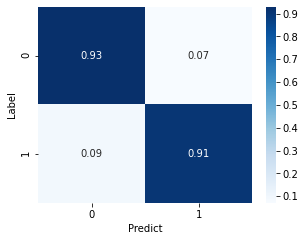

INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.102.27.98:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.102.27.98:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 64) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 64) dtype=int32>]


[2021-09-15 14:09:35] - tf-roberta-base-2021_fold1 inference
INFO:/content/drive/MyDrive/SRWS/output/210913_1:[2021-09-15 14:09:35] - tf-roberta-base-2021_fold1 inference


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.102.27.98:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.102.27.98:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 64) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 64) dtype=int32>]


[2021-09-15 14:11:43] - tf-roberta-base-2021_fold2 inference
INFO:/content/drive/MyDrive/SRWS/output/210913_1:[2021-09-15 14:11:43] - tf-roberta-base-2021_fold2 inference


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.102.27.98:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.102.27.98:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 64) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 64) dtype=int32>]


[2021-09-15 14:13:43] - tf-roberta-base-2021_fold3 inference
INFO:/content/drive/MyDrive/SRWS/output/210913_1:[2021-09-15 14:13:43] - tf-roberta-base-2021_fold3 inference


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.102.27.98:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.102.27.98:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 64) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 64) dtype=int32>]


[2021-09-15 14:15:43] - tf-roberta-base-2021_fold4 inference
INFO:/content/drive/MyDrive/SRWS/output/210913_1:[2021-09-15 14:15:43] - tf-roberta-base-2021_fold4 inference


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.102.27.98:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.102.27.98:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 64) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 64) dtype=int32>]


[2021-09-15 14:17:40] - tf-roberta-base-2021_fold5 inference
INFO:/content/drive/MyDrive/SRWS/output/210913_1:[2021-09-15 14:17:40] - tf-roberta-base-2021_fold5 inference


FileNotFoundError: ignored

In [ ]:
if __name__ == "__main__":
    main()